<a href="https://colab.research.google.com/github/ppkgtmm/emotion/blob/cnn-rnn/cnn_rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# !pip install -q keras-tuner
# !rm -r emotion
# !git clone --branch cnn-rnn https://github.com/ppkgtmm/emotion.git emotion

In [12]:
import pandas as pd
import numpy as np
from keras.preprocessing.text import  Tokenizer
from emotion.models import utils, cnn_rnn
from kerastuner.tuners.bayesian import BayesianOptimization
from kerastuner import HyperParameters

In [17]:
num_words = 15000
max_len = 300
hp = HyperParameters()
hp.Fixed('output_dim', 256)
hp.Fixed('optimizer', 'amsgrad')
hp.Fixed('max_len', max_len)
hp.Fixed('num_words', num_words)
hp.Fixed('gru_units', 64)
hp.Fixed('log2_filter', 7)
hp.Fixed('kernel_size', 5)
hp.Fixed('pool_size', 2)
hp.Fixed('activation', 'relu')
seed = 1234

In [5]:
train, test = utils.read_and_split()
train.sample(5)

,text,target
8454,i feel a cool breeze and think it might be col...,joy
2393,i feel like a child who got one lick of the mo...,joy
16613,i am feeling like something sweet there is alw...,love
10200,i feel thankful for everything in my life ever...,joy
12269,i have been too worried about money and the st...,joy


In [9]:
tokenizer = Tokenizer(num_words=num_words, oov_token='OOV')
tokenizer.fit_on_texts(train['text'])

In [10]:
sequence_train = utils.get_sequences(tokenizer, train['text'], max_len)
sequence_test = utils.get_sequences(tokenizer, test['text'], max_len)

In [11]:
target_train = utils.OH_fit_transform(train['target'])
target_test = utils.OH_transform(test['target'])

In [18]:
tuner = BayesianOptimization( cnn_rnn.build_model,
                              'val_accuracy',
                              12,
                              executions_per_trial=2,
                              hyperparameters=hp, 
                              seed=seed,
                              num_initial_points=5,
                              project_name='/content/drive/MyDrive/__ed__/cnn_rnn_B32',
                            )

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 256)          3840000   
_________________________________________________________________
conv1d (Conv1D)              (None, 296, 32)           40992     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 148, 32)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 144, 64)           10304     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 72, 64)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 68, 128)           41088     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 34, 128)           0

In [19]:
history = tuner.search(
            sequence_train, target_train,
            validation_split=0.1,
            epochs=5)

Trial 1 Complete [00h 06m 07s]
val_accuracy: 0.919705867767334

Best val_accuracy So Far: 0.919705867767334
Total elapsed time: 00h 06m 07s
INFO:tensorflow:Oracle triggered exit


In [20]:
tuner.search_space_summary()

Search space summary
Default search space size: 9
output_dim (Fixed)
{'conditions': [], 'value': 256}
optimizer (Fixed)
{'conditions': [], 'value': 'amsgrad'}
max_len (Fixed)
{'conditions': [], 'value': 300}
num_words (Fixed)
{'conditions': [], 'value': 15000}
gru_units (Fixed)
{'conditions': [], 'value': 64}
log2_filter (Fixed)
{'conditions': [], 'value': 7}
kernel_size (Fixed)
{'conditions': [], 'value': 5}
pool_size (Fixed)
{'conditions': [], 'value': 2}
activation (Fixed)
{'conditions': [], 'value': 'relu'}


In [21]:
tuner.results_summary(num_trials=3)

Results summary
Results in /content/drive/MyDrive/__ed__/cnn_rnn_B32
Showing 3 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
output_dim: 256
optimizer: amsgrad
max_len: 300
num_words: 15000
gru_units: 64
log2_filter: 7
kernel_size: 5
pool_size: 2
activation: relu
Score: 0.919705867767334


In [22]:
best_model = tuner.get_best_models(num_models=1)[0]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 256)          3840000   
_________________________________________________________________
conv1d (Conv1D)              (None, 296, 32)           40992     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 148, 32)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 144, 64)           10304     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 72, 64)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 68, 128)           41088     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 34, 128)           0

94/94 [==============================] - 1s 10ms/step
Accuracy:	90.6%


              precision    recall  f1-score   support

       anger       0.97      0.88      0.92       406
        fear       0.81      0.87      0.84       356
         joy       0.92      0.93      0.92      1014
        love       0.77      0.83      0.80       246
     sadness       0.95      0.97      0.96       870
    surprise       0.83      0.62      0.71       108

    accuracy                           0.91      3000
   macro avg       0.87      0.85      0.86      3000
weighted avg       0.91      0.91      0.91      3000



<Figure size 432x288 with 0 Axes>

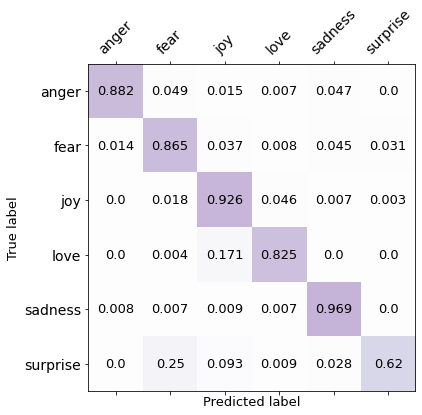

In [23]:
utils.model_evaluate(best_model, sequence_test, target_test, 32)

In [24]:
model = cnn_rnn.build_model(tuner.get_best_hyperparameters(num_trials=1)[0])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 256)          3840000   
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 296, 32)           40992     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 148, 32)           0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 144, 64)           10304     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 72, 64)            0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 68, 128)           41088     
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 34, 128)          

In [25]:
cb = utils.get_callbacks("cnn_rnn.h5")

In [26]:
history = model.fit(sequence_train, target_train, validation_split=0.1,
            epochs=100, callbacks=cb)

Epoch 1/100
479/479 [==============================] - 39s 77ms/step - loss: 1.4445 - accuracy: 0.4136 - precision_1: 0.6056 - recall_1: 0.1132 - val_loss: 0.4239 - val_accuracy: 0.8571 - val_precision_1: 0.9014 - val_recall_1: 0.8224

Epoch 00001: val_accuracy improved from -inf to 0.85706, saving model to cnn_rnn.h5
Epoch 2/100
479/479 [==============================] - 36s 75ms/step - loss: 0.3073 - accuracy: 0.8958 - precision_1: 0.9189 - recall_1: 0.8779 - val_loss: 0.2756 - val_accuracy: 0.9088 - val_precision_1: 0.9335 - val_recall_1: 0.8924

Epoch 00002: val_accuracy improved from 0.85706 to 0.90882, saving model to cnn_rnn.h5
Epoch 3/100
479/479 [==============================] - 35s 73ms/step - loss: 0.1303 - accuracy: 0.9529 - precision_1: 0.9640 - recall_1: 0.9433 - val_loss: 0.2244 - val_accuracy: 0.9194 - val_precision_1: 0.9332 - val_recall_1: 0.9124

Epoch 00003: val_accuracy improved from 0.90882 to 0.91941, saving model to cnn_rnn.h5
Epoch 4/100
479/479 [=============

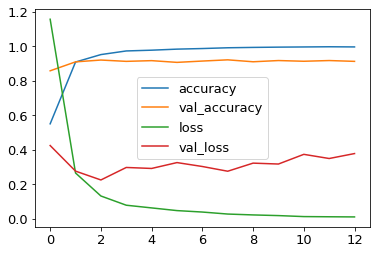

In [29]:
metr = ['accuracy','val_accuracy', 'loss', 'val_loss']
pd.DataFrame(history.history)[metr].plot()

94/94 [==============================] - 1s 9ms/step
Accuracy:	90.8%


              precision    recall  f1-score   support

       anger       0.89      0.90      0.89       406
        fear       0.88      0.83      0.86       356
         joy       0.92      0.93      0.93      1014
        love       0.81      0.84      0.83       246
     sadness       0.96      0.96      0.96       870
    surprise       0.73      0.71      0.72       108

    accuracy                           0.91      3000
   macro avg       0.87      0.86      0.86      3000
weighted avg       0.91      0.91      0.91      3000



<Figure size 432x288 with 0 Axes>

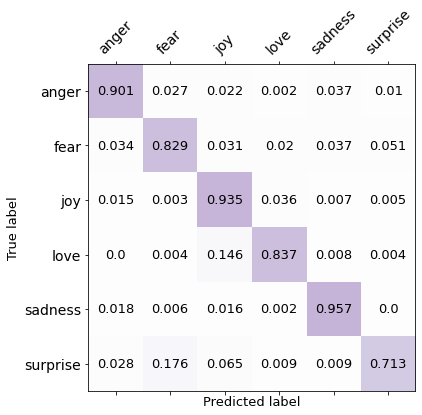

In [30]:
utils.model_evaluate(model, sequence_test, target_test, 32)

In [31]:
# utils.dump(tokenizer,'/content/drive/MyDrive/__ed__/cnn_rnn_B32/tokenizer.pickle')
# utils.dump(history.history,'/content/drive/MyDrive/__ed__/cnn_rnn_B32/history.pickle')

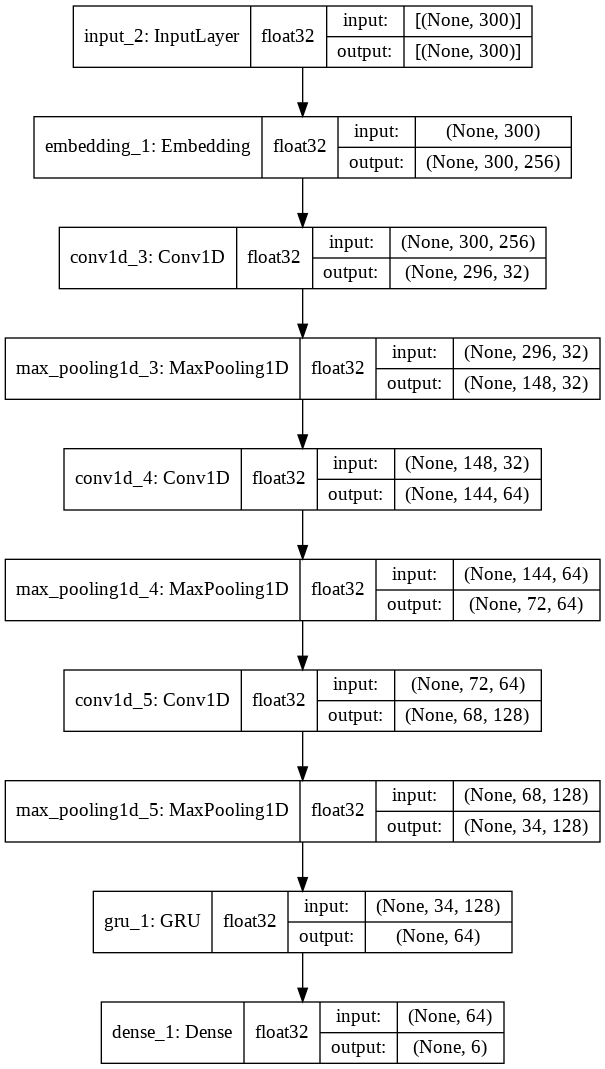

In [32]:
from keras.utils import plot_model
plot_model(
    model,
    to_file='/content/drive/MyDrive/__ed__/cnn_rnn_B32/plot.png',
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True
    )